# Import Library

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D,BatchNormalization, Flatten, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix

import random
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from pathlib import Path
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
sns.set_style('darkgrid')

# Check GPU Usage

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU ditemukan: {len(gpus)} GPU tersedia.")
    for gpu in gpus:
        print(f" - {gpu}")
else:
    print("Tidak ada GPU yang terdeteksi.")

GPU ditemukan: 1 GPU tersedia.
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Load Dataset

In [3]:
dataset_dir = '../New_Dataset/skin_cancer_dataset'

train_dir = '../New_Dataset/model_dataset/train'
val_dir = '../New_Dataset/model_dataset/val'

# Splitting Dataset

- Split the Dataset into Traning and Validation

In [ ]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        
        images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
        
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
        
        for img in train_images:
            shutil.move(img, os.path.join(train_class_dir, os.path.basename(img)))
        
        for img in val_images:
            shutil.move(img, os.path.join(val_class_dir, os.path.basename(img)))

print("Dataset telah dibagi menjadi folder train dan val!")

Dataset telah dibagi menjadi folder train dan val!


- Swow the Number of Training and Validation Data

In [3]:
train_dir = Path('../New_Dataset/model_dataset/train')
val_dir = Path('../New_Dataset/model_dataset/val')

image_count_train = len(list(train_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(val_dir.glob('*/*.jpg')))
print(image_count_test)

2328
588


In [4]:
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

print('---Training Data---')

class_counts = count_images_in_classes(train_dir)

print("Jumlah gambar per kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

print('\n---Validation Data---')

class_counts_val = count_images_in_classes(val_dir)

print("Jumlah gambar per kelas:")
for class_name, count in class_counts_val.items():
    print(f"{class_name}: {count}")


---Training Data---
Jumlah gambar per kelas:
acne: 202
actinic keratosis: 104
basal cell carcinoma: 313
dermatofibroma: 88
melanoma: 363
nevus: 298
normal: 244
pigmented benign keratosis: 382
seborrheic keratosis: 64
squamous cell carcinoma: 157
vascular lesion: 113

---Validation Data---
Jumlah gambar per kelas:
acne: 51
actinic keratosis: 26
basal cell carcinoma: 79
dermatofibroma: 23
melanoma: 91
nevus: 75
normal: 62
pigmented benign keratosis: 96
seborrheic keratosis: 16
squamous cell carcinoma: 40
vascular lesion: 29


# Preprocessing Data

- Prepare the Dataset

In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
RND_SEED = 123
random.seed(RND_SEED)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 2328 files belonging to 11 classes.
Using 1863 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                             validation_split=0.2,
                                                             subset="validation",
                                                             seed=123,
                                                             image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             batch_size=BATCH_SIZE)

Found 2328 files belonging to 11 classes.
Using 465 files for validation.


In [8]:
test_ds= tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                             validation_split=0.9,
                                                             subset="validation",
                                                             seed=123,
                                                             image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             batch_size=BATCH_SIZE)

Found 588 files belonging to 11 classes.
Using 529 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['acne', 'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'normal', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


- Dataset Preview

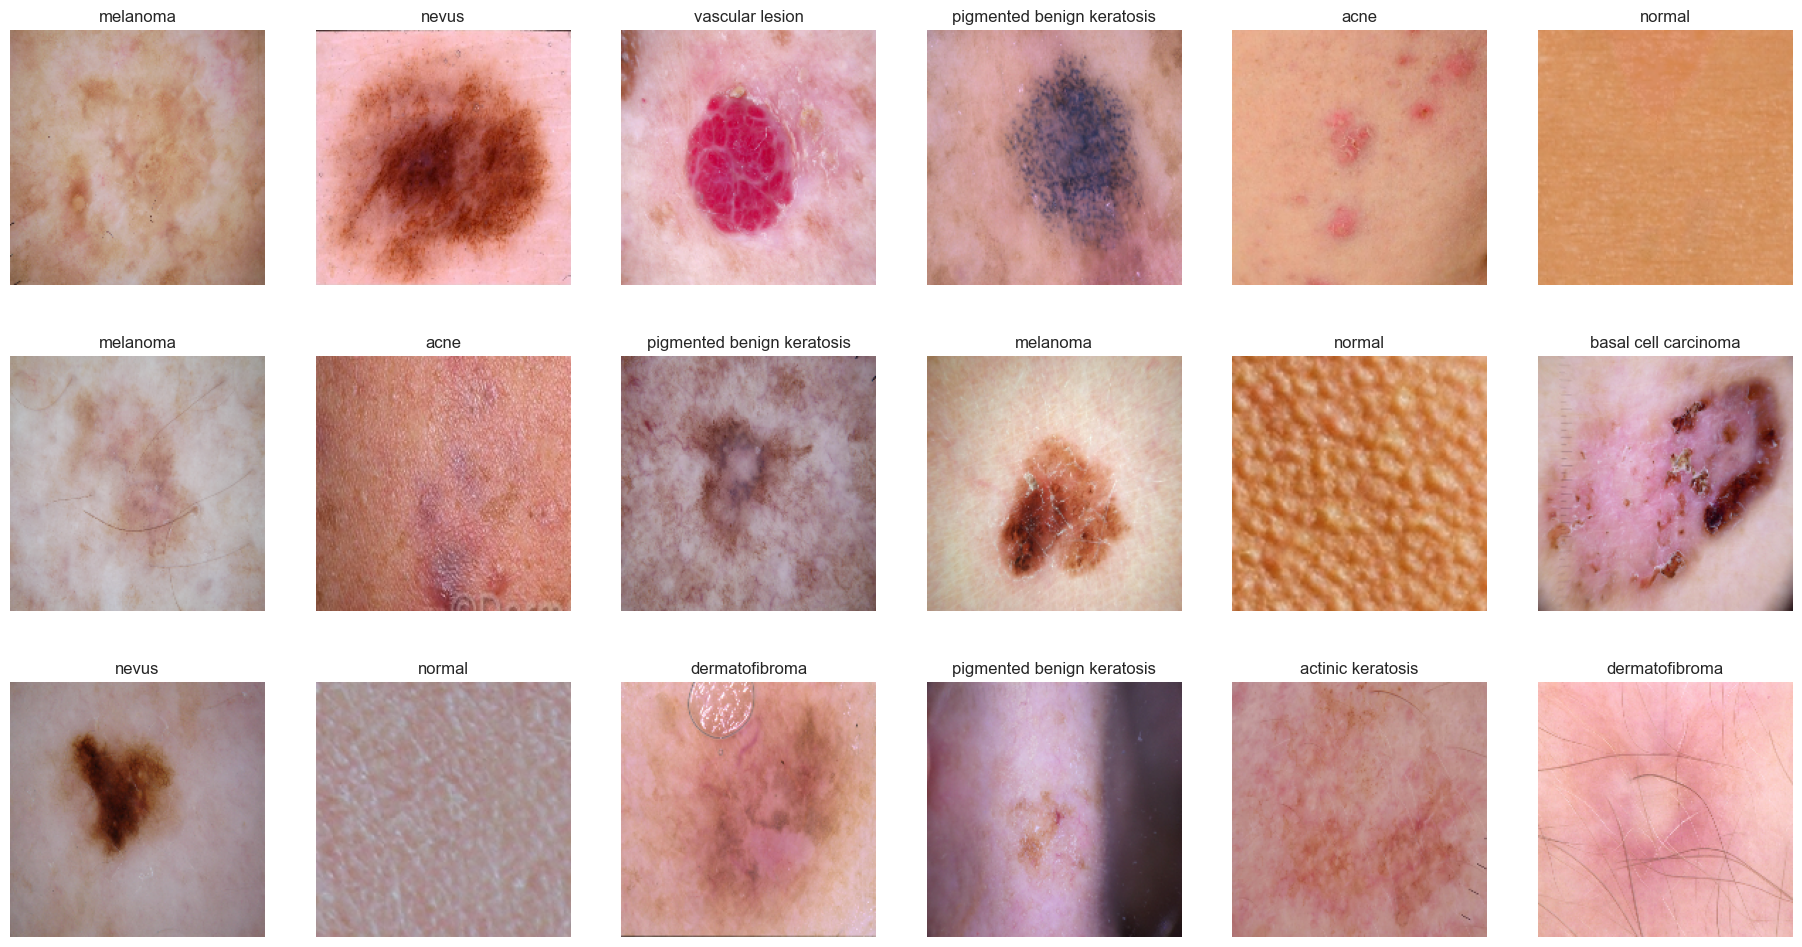

In [11]:
plt.figure(figsize=(23, 12))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 1st Model CNN

- Modeling

In [16]:
num_classes = 11
model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [17]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 128)      

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback ModelCheckpoint untuk menyimpan model terbaik berdasarkan val_loss
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [21]:
epochs = 25
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25


59/59 [==============================] - 7s 113ms/step - loss: 2.3085 - accuracy: 0.1455 - val_loss: 2.2645 - val_accuracy: 0.1462
Epoch 2/25
59/59 [==============================] - 4s 74ms/step - loss: 2.2548 - accuracy: 0.1492 - val_loss: 2.2605 - val_accuracy: 0.1699
Epoch 3/25
59/59 [==============================] - 4s 73ms/step - loss: 2.1786 - accuracy: 0.2077 - val_loss: 2.0571 - val_accuracy: 0.2860
Epoch 4/25
59/59 [==============================] - 4s 73ms/step - loss: 2.0377 - accuracy: 0.2523 - val_loss: 1.8961 - val_accuracy: 0.3398
Epoch 5/25
59/59 [==============================] - 4s 73ms/step - loss: 1.8220 - accuracy: 0.3688 - val_loss: 1.7825 - val_accuracy: 0.3333
Epoch 6/25
59/59 [==============================] - 4s 74ms/step - loss: 1.6265 - accuracy: 0.4482 - val_loss: 1.5837 - val_accuracy: 0.4688
Epoch 7/25
59/59 [==============================] - 4s 73ms/step - loss: 1.5664 - accuracy: 0.4579 - val_loss: 1.4984 - val_accuracy: 0.4538
Epoch 8/25
59/59 [=====

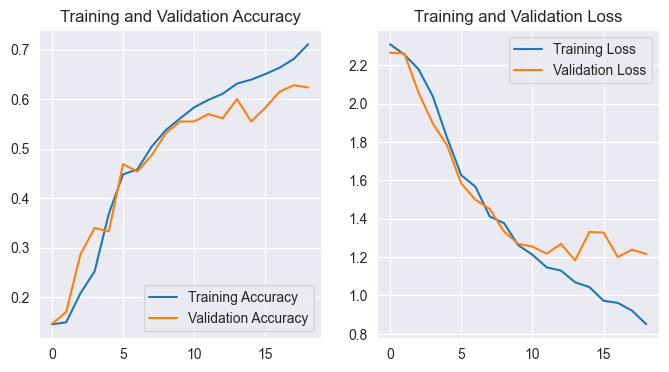

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(19)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
(eval_loss, eval_accuracy) = model.evaluate(val_ds, batch_size=BATCH_SIZE, \
                                            verbose=1)

15/15 [==============================] - 1s 19ms/step - loss: 1.1832 - accuracy: 0.6000


In [25]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 

[INFO] accuracy: 60.00%
[INFO] Loss: 1.1831668615341187


1/1 [==============================] - 0s 75ms/step


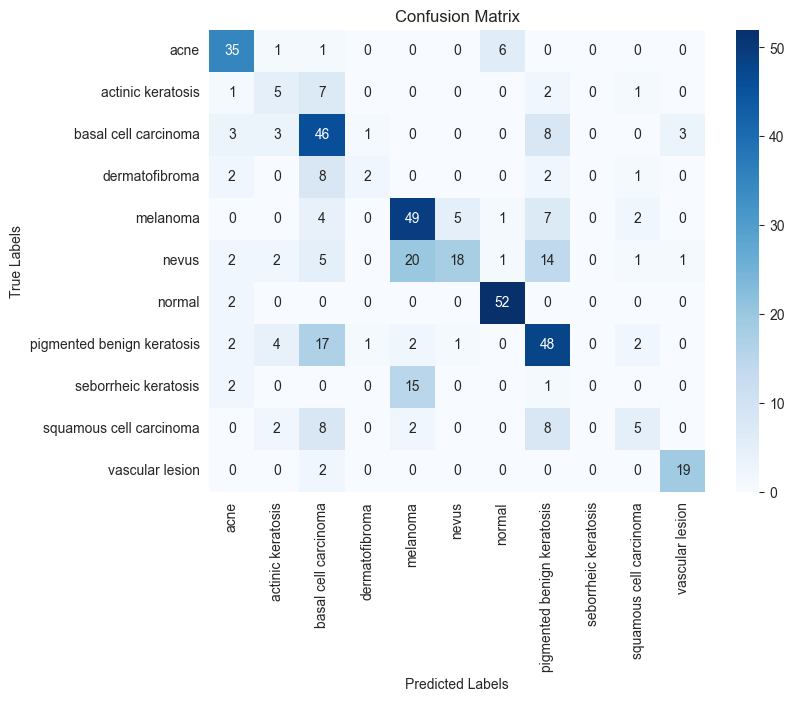

In [26]:
y_true = []
y_pred = []

# Mengambil batch dari validasi dan melakukan prediksi
for images, labels in val_ds:
    # Prediksi model terhadap batch gambar
    predictions = model.predict(images)
    
    # Menyimpan label asli dan prediksi
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Mengambil kelas dengan probabilitas tertinggi

# Menghitung confusion matrix
cm = confusion_matrix(np.array(y_true), np.array(y_pred))

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Data Augmentation

In [12]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

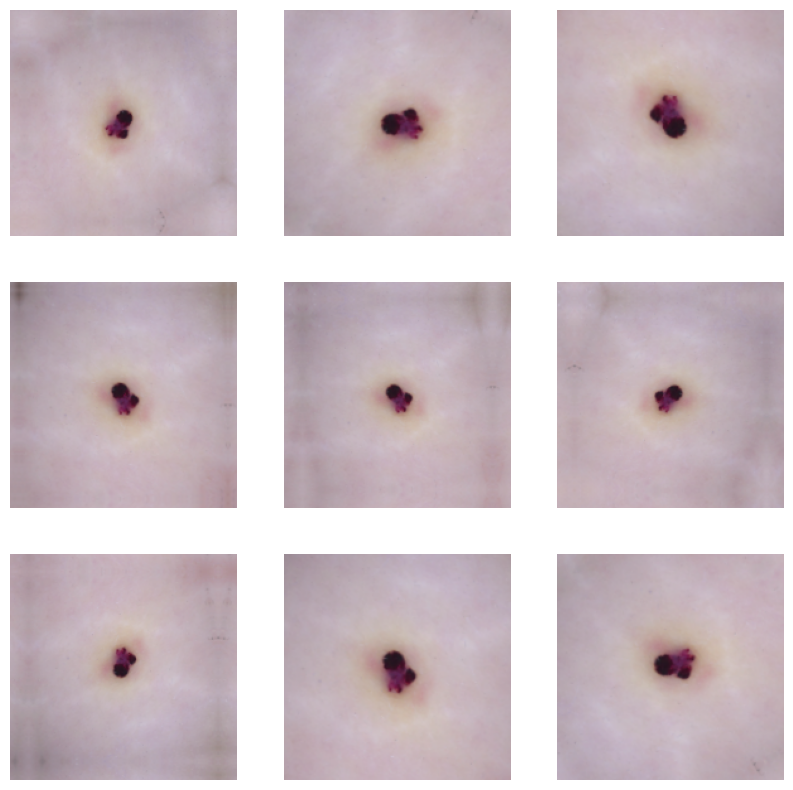

In [38]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# 2nd Model CNN

In [29]:
model2 = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3))])

model2.add(Conv2D(32, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(64, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(128, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.15))

model2.add(Conv2D(256, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.20))

model2.add(Conv2D(512, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(1024,activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(units=num_classes, activation= 'softmax'))

In [30]:
opt = Adam(lr=0.001)
model2.compile(optimizer= opt,
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [31]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 128)      

In [32]:
epochs = 25

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint2 = ModelCheckpoint('model2.h5', monitor='val_loss', save_best_only=True)

history2 = model2.fit(train_ds,
                      validation_data=val_ds,
                      epochs=epochs,
                      callbacks=[early_stopping, checkpoint]
)

Epoch 1/25


c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


59/59 [==============================] - 5s 72ms/step - loss: 2.3118 - accuracy: 0.1551 - val_loss: 2.2575 - val_accuracy: 0.1656
Epoch 2/25
59/59 [==============================] - 4s 69ms/step - loss: 2.2487 - accuracy: 0.1648 - val_loss: 2.2553 - val_accuracy: 0.1720
Epoch 3/25
59/59 [==============================] - 4s 69ms/step - loss: 2.0849 - accuracy: 0.2517 - val_loss: 1.9598 - val_accuracy: 0.3269
Epoch 4/25
59/59 [==============================] - 4s 68ms/step - loss: 1.9306 - accuracy: 0.3086 - val_loss: 1.8854 - val_accuracy: 0.3097
Epoch 5/25
59/59 [==============================] - 4s 68ms/step - loss: 1.7650 - accuracy: 0.3698 - val_loss: 1.6915 - val_accuracy: 0.4237
Epoch 6/25
59/59 [==============================] - 4s 68ms/step - loss: 1.6778 - accuracy: 0.4219 - val_loss: 1.6448 - val_accuracy: 0.3828
Epoch 7/25
59/59 [==============================] - 4s 68ms/step - loss: 1.5207 - accuracy: 0.4675 - val_loss: 1.4693 - val_accuracy: 0.5011
Epoch 8/25
59/59 [======

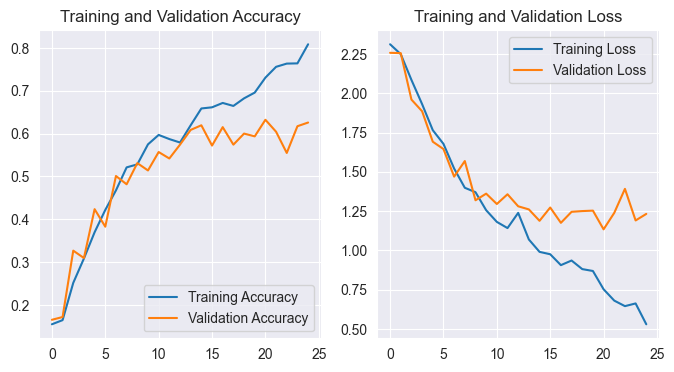

In [33]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
(eval_loss2, eval_accuracy2) = model.evaluate(val_ds, batch_size=BATCH_SIZE, \
                                            verbose=1)

15/15 [==============================] - 1s 19ms/step - loss: 1.1832 - accuracy: 0.6000


In [35]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy2 * 100)) 
print("[INFO] Loss: {}".format(eval_loss2)) 

[INFO] accuracy: 60.00%
[INFO] Loss: 1.1831668615341187


1/1 [==============================] - 0s 67ms/step


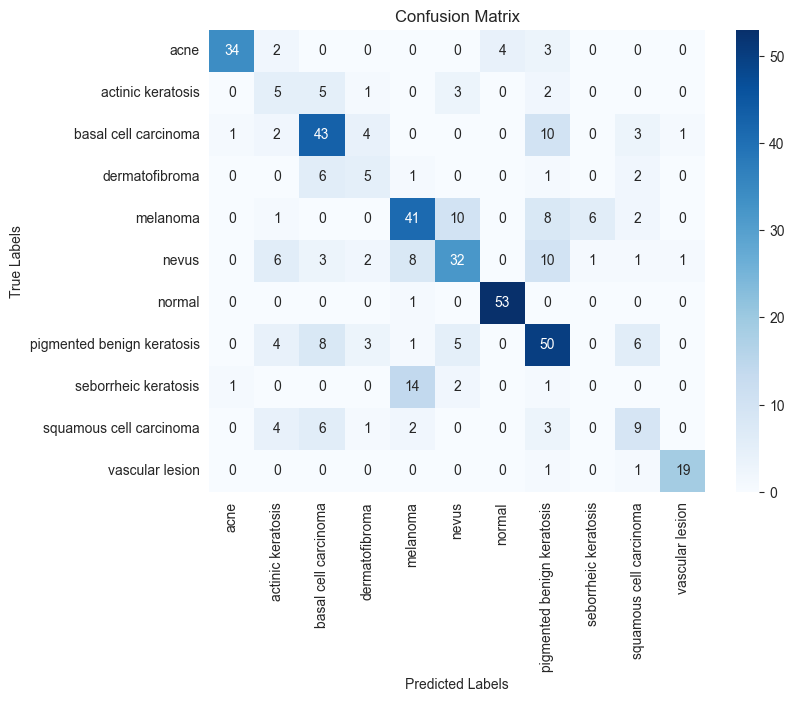

In [36]:
y_true = []
y_pred = []

# Mengambil batch dari validasi dan melakukan prediksi
for images, labels in val_ds:
    # Prediksi model terhadap batch gambar
    predictions = model2.predict(images)
    
    # Menyimpan label asli dan prediksi
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Mengambil kelas dengan probabilitas tertinggi

# Menghitung confusion matrix
cm = confusion_matrix(np.array(y_true), np.array(y_pred))

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Equalize Data

total training image count = 2328 

-------------------------------------
Class name =  acne
count      =  202
proportion =  0.08676975945017182
-------------------------------------
Class name =  actinic keratosis
count      =  104
proportion =  0.044673539518900345
-------------------------------------
Class name =  basal cell carcinoma
count      =  313
proportion =  0.13445017182130584
-------------------------------------
Class name =  dermatofibroma
count      =  88
proportion =  0.037800687285223365
-------------------------------------
Class name =  melanoma
count      =  363
proportion =  0.1559278350515464
-------------------------------------
Class name =  nevus
count      =  298
proportion =  0.12800687285223367
-------------------------------------
Class name =  normal
count      =  244
proportion =  0.10481099656357389
-------------------------------------
Class name =  pigmented benign keratosis
count      =  382
proportion =  0.1640893470790378
-------------------------

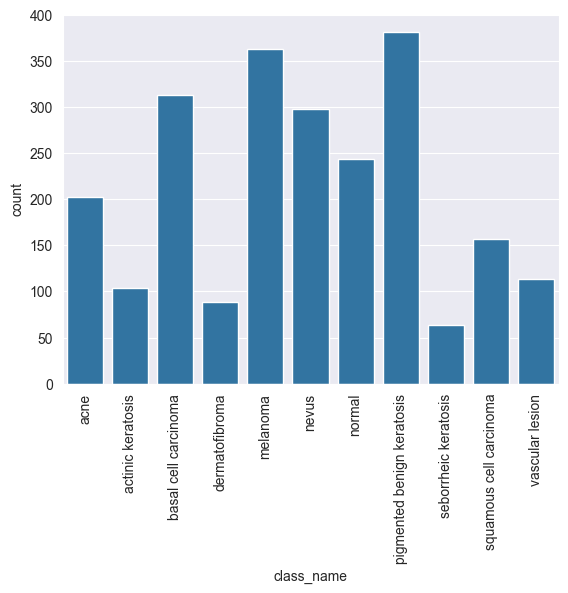

In [37]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [49]:
%pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [19]:
print(class_names)

['acne', 'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'normal', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [21]:
path_to_training_dataset = '../New_Dataset/model_dataset/train/'

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='../New_Dataset/model_dataset/train/output/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) 

Initialised with 202 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/acne\../New_Dataset/model_dataset/train/output/acne.

Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Processing <PIL.Image.Image image mode=RGB size=256x166 at 0x2178FC55C70>: 100%|██████████| 1000/1000 [00:01<00:00, 610.05 Samples/s]                  


Initialised with 104 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/actinic keratosis\../New_Dataset/model_dataset/train/output/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2171C1550D0>: 100%|██████████| 1000/1000 [00:02<00:00, 354.62 Samples/s]                   


Initialised with 313 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/basal cell carcinoma\../New_Dataset/model_dataset/train/output/basal cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2178FB329A0>: 100%|██████████| 1000/1000 [00:02<00:00, 374.18 Samples/s]


Initialised with 88 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/dermatofibroma\../New_Dataset/model_dataset/train/output/dermatofibroma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2178FB7E4F0>: 100%|██████████| 1000/1000 [00:26<00:00, 37.54 Samples/s]  


Initialised with 363 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/melanoma\../New_Dataset/model_dataset/train/output/melanoma.

Processing <PIL.Image.Image image mode=RGB size=722x540 at 0x2178FC1F8B0>: 100%|██████████| 1000/1000 [00:11<00:00, 83.73 Samples/s]                    


Initialised with 298 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/nevus\../New_Dataset/model_dataset/train/output/nevus.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x2178FD68700>: 100%|██████████| 1000/1000 [00:10<00:00, 96.96 Samples/s]                  


Initialised with 244 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/normal\../New_Dataset/model_dataset/train/output/normal.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x2178FC90790>: 100%|██████████| 1000/1000 [00:02<00:00, 426.74 Samples/s]                   


Initialised with 382 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/pigmented benign keratosis\../New_Dataset/model_dataset/train/output/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2171C06B1F0>: 100%|██████████| 1000/1000 [00:02<00:00, 384.16 Samples/s]                 


Initialised with 64 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/seborrheic keratosis\../New_Dataset/model_dataset/train/output/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2178FC1EFA0>: 100%|██████████| 1000/1000 [00:05<00:00, 196.31 Samples/s]                 


Initialised with 157 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/squamous cell carcinoma\../New_Dataset/model_dataset/train/output/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2178FC44880>: 100%|██████████| 1000/1000 [00:10<00:00, 92.97 Samples/s]                    


Initialised with 113 image(s) found.
Output directory set to ../New_Dataset/model_dataset/train/vascular lesion\../New_Dataset/model_dataset/train/output/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x216AB0E2940>: 100%|██████████| 1000/1000 [00:02<00:00, 380.18 Samples/s]                 


In [14]:
output_dir = Path('../New_Dataset/model_dataset/output_dataset')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

11000


total training image count = 11000 

-------------------------------------
Class name =  acne
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  normal
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.09090909090909091
---------------

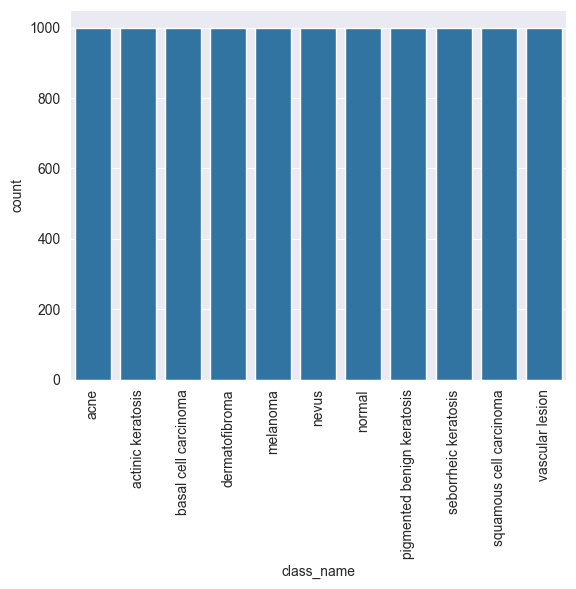

In [15]:
num_classes = 11

total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(output_dir,
                                                               seed=123,
                                                               validation_split = 0.2,
                                                               subset = 'training',
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 11000 files belonging to 11 classes.
Using 8800 files for training.


In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(output_dir,
                                                            seed=123,
                                                            validation_split = 0.2,
                                                            subset = 'validation',
                                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                            batch_size=BATCH_SIZE)

Found 11000 files belonging to 11 classes.
Using 2200 files for validation.


In [18]:
print(train_ds.class_names)

['acne', 'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'normal', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# 3rd Model CNN

In [43]:
model3 = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3))])

model3.add(Conv2D(32, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(64, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(128, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.15))

model3.add(Conv2D(256, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.20))

model3.add(Conv2D(512, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(1024,activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(units=num_classes, activation= 'softmax'))

In [44]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 45, 45, 128)      

In [45]:
opt = Adam(lr=0.001)
model3.compile(optimizer= opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint('../Model/model3.h5', monitor='val_loss', save_best_only=True)

c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [60]:
epochs = 25
history4 = model3.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25


275/275 [==============================] - 27s 97ms/step - loss: 0.3405 - accuracy: 0.8761 - val_loss: 0.7779 - val_accuracy: 0.7645
Epoch 2/25
275/275 [==============================] - 20s 73ms/step - loss: 0.3473 - accuracy: 0.8784 - val_loss: 0.6458 - val_accuracy: 0.8164
Epoch 3/25
275/275 [==============================] - 20s 74ms/step - loss: 0.3498 - accuracy: 0.8786 - val_loss: 0.5559 - val_accuracy: 0.8214
Epoch 4/25
275/275 [==============================] - 21s 76ms/step - loss: 0.5301 - accuracy: 0.8633 - val_loss: 0.6668 - val_accuracy: 0.7818
Epoch 5/25
275/275 [==============================] - 20s 74ms/step - loss: 0.3365 - accuracy: 0.8832 - val_loss: 0.5909 - val_accuracy: 0.8168
Epoch 6/25
275/275 [==============================] - 20s 72ms/step - loss: 0.3063 - accuracy: 0.8924 - val_loss: 0.7478 - val_accuracy: 0.7686
Epoch 7/25
275/275 [==============================] - 20s 73ms/step - loss: 0.3121 - accuracy: 0.8860 - val_loss: 0.6902 - val_accuracy: 0.7745
Epo

In [ ]:
(eval_loss3, eval_accuracy3) = model3.evaluate(val_ds, batch_size=BATCH_SIZE, \
                                            verbose=1)

69/69 [==============================] - 2s 26ms/step - loss: 0.5559 - accuracy: 0.8214


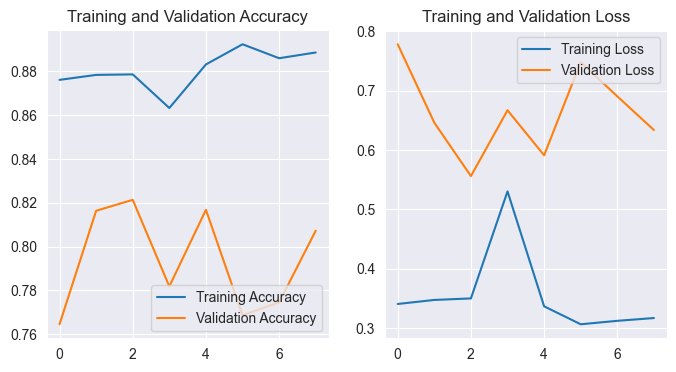

In [63]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy3 * 100)) 
print("[INFO] Loss: {}".format(eval_loss3)) 

[INFO] accuracy: 82.14%
[INFO] Loss: 0.5558788776397705


1/1 [==============================] - 0s 22ms/step


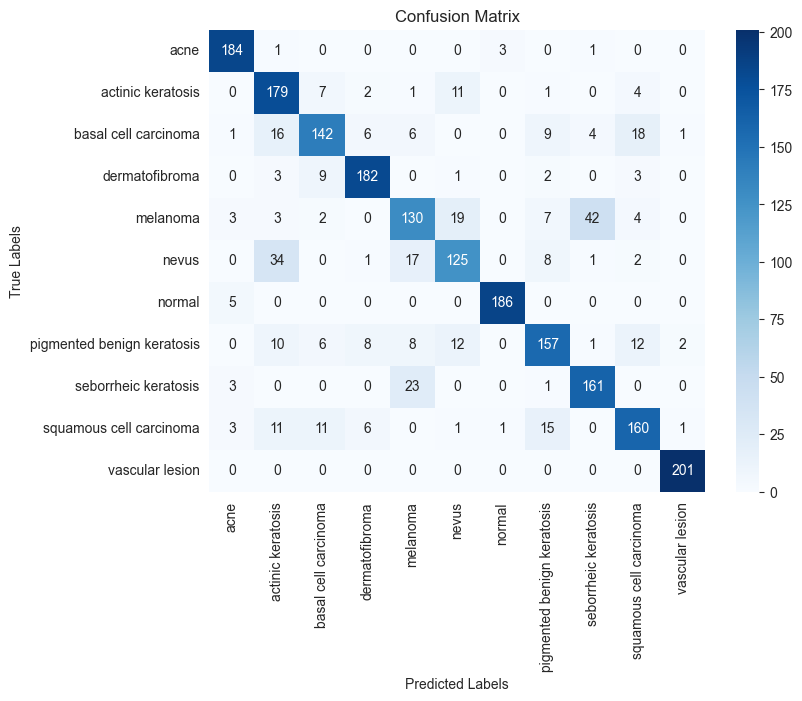

In [65]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Melakukan prediksi pada data validasi
y_true = []
y_pred = []

# Mengambil batch dari validasi dan melakukan prediksi
for images, labels in val_ds:
    # Prediksi model terhadap batch gambar
    predictions = model3.predict(images)
    
    # Menyimpan label asli dan prediksi
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Mengambil kelas dengan probabilitas tertinggi

# Menghitung confusion matrix
cm = confusion_matrix(np.array(y_true), np.array(y_pred))

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [66]:
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred)

# Menampilkan classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                            precision    recall  f1-score   support

                      acne       0.92      0.97      0.95       189
         actinic keratosis       0.70      0.87      0.77       205
      basal cell carcinoma       0.80      0.70      0.75       203
            dermatofibroma       0.89      0.91      0.90       200
                  melanoma       0.70      0.62      0.66       210
                     nevus       0.74      0.66      0.70       188
                    normal       0.98      0.97      0.98       191
pigmented benign keratosis       0.79      0.73      0.75       216
      seborrheic keratosis       0.77      0.86      0.81       188
   squamous cell carcinoma       0.79      0.77      0.78       209
           vascular lesion       0.98      1.00      0.99       201

                  accuracy                           0.82      2200
                 macro avg       0.82      0.82      0.82      2200
              weighted avg       0.82      0.8

In [67]:
model3.save('../Model/model3_v2.h5')

# Prepare Dataset For Categorical Crossentropy 

In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)

train_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_train_data = train_generator.samples
num_val_data = validation_generator.samples

print(f"Jumlah data training: {num_train_data}")
print(f"Jumlah data validasi: {num_val_data}")

Found 8800 images belonging to 11 classes.
Found 2200 images belonging to 11 classes.
Jumlah data training: 8800
Jumlah data validasi: 2200


In [45]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : acne
1 : actinic keratosis
2 : basal cell carcinoma
3 : dermatofibroma
4 : melanoma
5 : nevus
6 : normal
7 : pigmented benign keratosis
8 : seborrheic keratosis
9 : squamous cell carcinoma
10 : vascular lesion


# 1st Model VGG

In [ ]:
def create_vgg16_model(input_shape, num_classes):
    base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    base_vgg_model.trainable = False

    vgg_model = tf.keras.models.Sequential([
        base_vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return vgg_model

vgg_model = create_vgg16_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=num_classes)
print(num_classes)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint('../Model/model_vgg.h5', monitor='val_loss', save_best_only=True)

11


In [22]:
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 11)                715       
                                                      

In [23]:
vgg_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

vgg_hist = vgg_model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25


c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


275/275 [==============================] - 42s 141ms/step - loss: 2.2787 - accuracy: 0.2274 - val_loss: 1.7419 - val_accuracy: 0.4282
Epoch 2/25
275/275 [==============================] - 38s 136ms/step - loss: 1.7822 - accuracy: 0.3659 - val_loss: 1.4697 - val_accuracy: 0.4991
Epoch 3/25
275/275 [==============================] - 38s 137ms/step - loss: 1.5427 - accuracy: 0.4340 - val_loss: 1.3160 - val_accuracy: 0.5423
Epoch 4/25
275/275 [==============================] - 38s 137ms/step - loss: 1.4075 - accuracy: 0.4805 - val_loss: 1.1853 - val_accuracy: 0.5800
Epoch 5/25
275/275 [==============================] - 38s 137ms/step - loss: 1.3196 - accuracy: 0.5133 - val_loss: 1.1038 - val_accuracy: 0.5882
Epoch 6/25
275/275 [==============================] - 38s 137ms/step - loss: 1.2334 - accuracy: 0.5335 - val_loss: 1.0602 - val_accuracy: 0.6136
Epoch 7/25
275/275 [==============================] - 38s 138ms/step - loss: 1.1557 - accuracy: 0.5694 - val_loss: 1.0211 - val_accuracy: 0.6

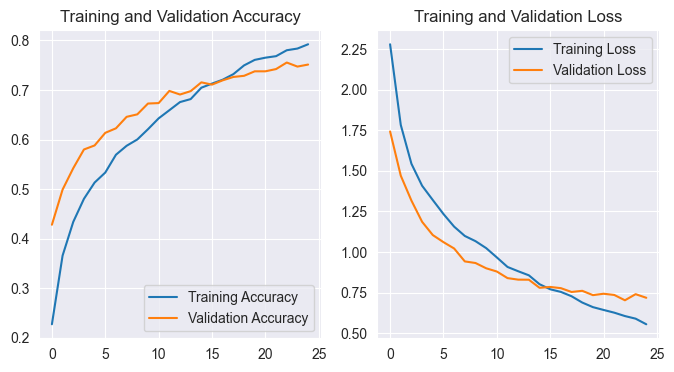

In [25]:
acc = vgg_hist.history['accuracy']
val_acc = vgg_hist.history['val_accuracy']

loss = vgg_hist.history['loss']
val_loss = vgg_hist.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
(eval_loss_vgg, eval_accuracy_vgg) = vgg_model.evaluate(val_ds, batch_size=BATCH_SIZE, \
                                            verbose=1)

69/69 [==============================] - 8s 111ms/step - loss: 0.7175 - accuracy: 0.7514


In [27]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy_vgg * 100)) 
print("[INFO] Loss: {}".format(eval_loss_vgg)) 

[INFO] accuracy: 75.14%
[INFO] Loss: 0.7175444960594177


1/1 [==============================] - 0s 98ms/step


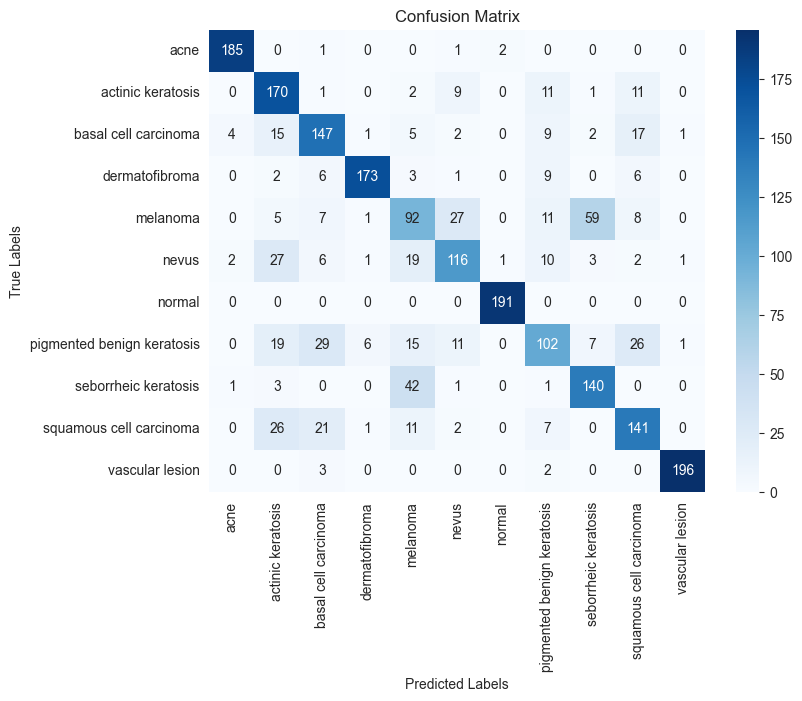

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Melakukan prediksi pada data validasi
y_true = []
y_pred = []

# Mengambil batch dari validasi dan melakukan prediksi
for images, labels in val_ds:
    # Prediksi model terhadap batch gambar
    predictions = vgg_model.predict(images)
    
    # Menyimpan label asli dan prediksi
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Mengambil kelas dengan probabilitas tertinggi

# Menghitung confusion matrix
cm = confusion_matrix(np.array(y_true), np.array(y_pred))

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred)

# Menampilkan classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                            precision    recall  f1-score   support

                      acne       0.96      0.98      0.97       189
         actinic keratosis       0.64      0.83      0.72       205
      basal cell carcinoma       0.67      0.72      0.69       203
            dermatofibroma       0.95      0.86      0.90       200
                  melanoma       0.49      0.44      0.46       210
                     nevus       0.68      0.62      0.65       188
                    normal       0.98      1.00      0.99       191
pigmented benign keratosis       0.63      0.47      0.54       216
      seborrheic keratosis       0.66      0.74      0.70       188
   squamous cell carcinoma       0.67      0.67      0.67       209
           vascular lesion       0.98      0.98      0.98       201

                  accuracy                           0.75      2200
                 macro avg       0.76      0.76      0.75      2200
              weighted avg       0.75      0.7

# 2nd Model VGG

In [ ]:
model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
vgg_model_2 = Sequential()

for layer in model_VGG16.layers:
    layer.trainable = False
    
vgg_model_2.add(model_VGG16)
vgg_model_2.add(Flatten())
vgg_model_2.add(Dropout(0.5))
vgg_model_2.add(Dense(512, activation='relu'))
vgg_model_2.add(Dense(256, activation='relu'))
vgg_model_2.add(Dense(128, activation='relu'))
vgg_model_2.add(Dense(64, activation='relu'))
vgg_model_2.add(Dense(num_classes, activation='softmax'))

vgg_model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout_2 (Dropout)         (None, 12800)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               6554112   
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)               

In [32]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint('../Model/model_vgg_2.h5', monitor='val_loss', save_best_only=True)

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
vgg_model_2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

vgg_hist_2 = vgg_model_2.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    epochs=25,
                    validation_data=val_ds,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/25


275/275 [==============================] - 39s 139ms/step - loss: 1.7784 - accuracy: 0.4049 - val_loss: 1.2392 - val_accuracy: 0.5523
Epoch 2/25
275/275 [==============================] - 38s 138ms/step - loss: 1.2336 - accuracy: 0.5487 - val_loss: 1.0752 - val_accuracy: 0.6018
Epoch 3/25
275/275 [==============================] - 38s 137ms/step - loss: 1.0435 - accuracy: 0.6226 - val_loss: 0.8762 - val_accuracy: 0.6686
Epoch 4/25
275/275 [==============================] - 38s 138ms/step - loss: 0.9062 - accuracy: 0.6699 - val_loss: 0.8766 - val_accuracy: 0.6759
Epoch 5/25
275/275 [==============================] - 38s 139ms/step - loss: 0.8201 - accuracy: 0.7026 - val_loss: 0.7990 - val_accuracy: 0.7068
Epoch 6/25
275/275 [==============================] - 38s 139ms/step - loss: 0.7567 - accuracy: 0.7300 - val_loss: 0.7661 - val_accuracy: 0.7232
Epoch 7/25
275/275 [==============================] - 38s 139ms/step - loss: 0.6736 - accuracy: 0.7561 - val_loss: 0.7010 - val_accuracy: 0.7

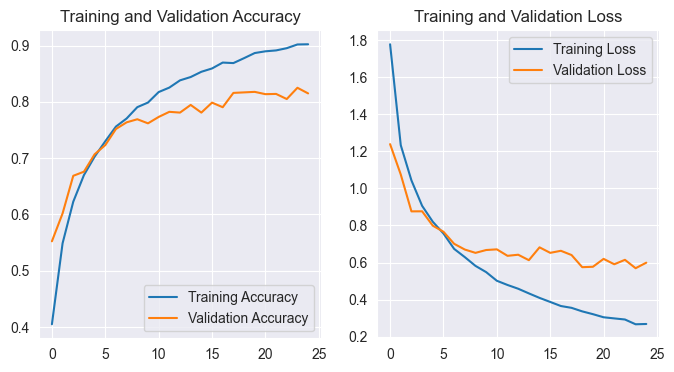

In [36]:
acc = vgg_hist_2.history['accuracy']
val_acc = vgg_hist_2.history['val_accuracy']

loss = vgg_hist_2.history['loss']
val_loss = vgg_hist_2.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
(eval_loss_vgg_2, eval_accuracy_vgg_2) = vgg_model_2.evaluate(val_ds, batch_size=BATCH_SIZE, \
                                            verbose=1)

69/69 [==============================] - 8s 111ms/step - loss: 0.5992 - accuracy: 0.8150


In [38]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy_vgg_2 * 100)) 
print("[INFO] Loss: {}".format(eval_loss_vgg_2)) 

[INFO] accuracy: 81.50%
[INFO] Loss: 0.5991857647895813


1/1 [==============================] - 0s 101ms/step


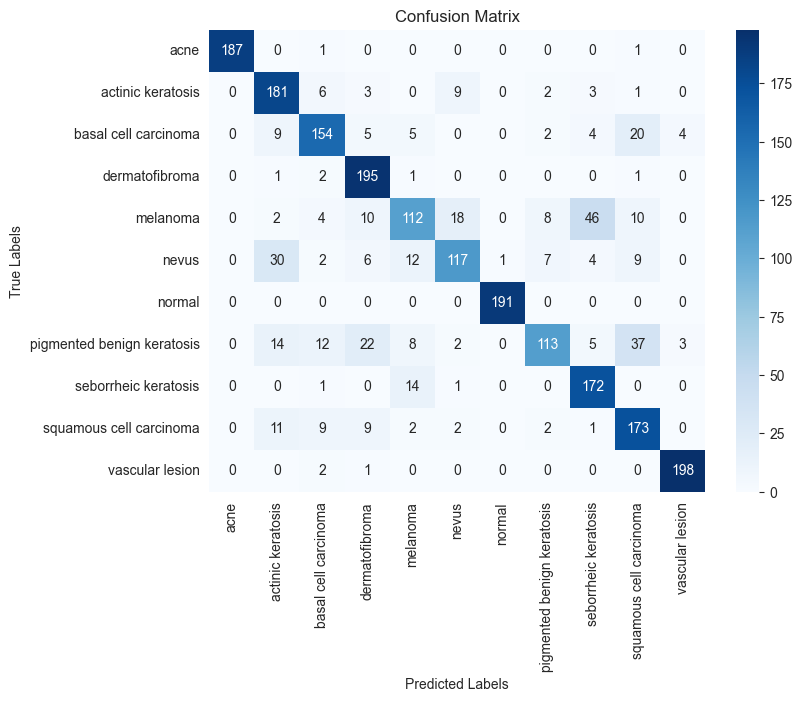

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Melakukan prediksi pada data validasi
y_true = []
y_pred = []

# Mengambil batch dari validasi dan melakukan prediksi
for images, labels in val_ds:
    # Prediksi model terhadap batch gambar
    predictions = vgg_model_2.predict(images)
    
    # Menyimpan label asli dan prediksi
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Mengambil kelas dengan probabilitas tertinggi

# Menghitung confusion matrix
cm = confusion_matrix(np.array(y_true), np.array(y_pred))

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [40]:
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred)

# Menampilkan classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                            precision    recall  f1-score   support

                      acne       1.00      0.99      0.99       189
         actinic keratosis       0.73      0.88      0.80       205
      basal cell carcinoma       0.80      0.76      0.78       203
            dermatofibroma       0.78      0.97      0.86       200
                  melanoma       0.73      0.53      0.62       210
                     nevus       0.79      0.62      0.69       188
                    normal       0.99      1.00      1.00       191
pigmented benign keratosis       0.84      0.52      0.65       216
      seborrheic keratosis       0.73      0.91      0.81       188
   squamous cell carcinoma       0.69      0.83      0.75       209
           vascular lesion       0.97      0.99      0.98       201

                  accuracy                           0.81      2200
                 macro avg       0.82      0.82      0.81      2200
              weighted avg       0.82      0.8

# Train 2nd Model VGG with LR reduction

In [56]:
opt = SGD(learning_rate=0.001, momentum=0.9)
vgg_model_2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

vgg_hist_3 = vgg_model_2.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    epochs=25,
                    validation_data=val_ds,
                    callbacks=[learning_rate_reduction, early_stopping, checkpoint])

Epoch 1/25


275/275 [==============================] - 41s 145ms/step - loss: 0.1415 - accuracy: 0.9502 - val_loss: 0.5701 - val_accuracy: 0.8459 - lr: 0.0010
Epoch 2/25
275/275 [==============================] - 38s 138ms/step - loss: 0.1231 - accuracy: 0.9563 - val_loss: 0.5968 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 3/25
275/275 [==============================] - 38s 138ms/step - loss: 0.1140 - accuracy: 0.9602 - val_loss: 0.6078 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 4/25
275/275 [==============================] - 38s 138ms/step - loss: 0.1145 - accuracy: 0.9606 - val_loss: 0.6201 - val_accuracy: 0.8445 - lr: 0.0010
Epoch 5/25
275/275 [==============================] - 38s 138ms/step - loss: 0.1006 - accuracy: 0.9647 - val_loss: 0.6325 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 6/25
275/275 [==============================] - 38s 139ms/step - loss: 0.0922 - accuracy: 0.9667 - val_loss: 0.6326 - val_accuracy: 0.8591 - lr: 0.0010


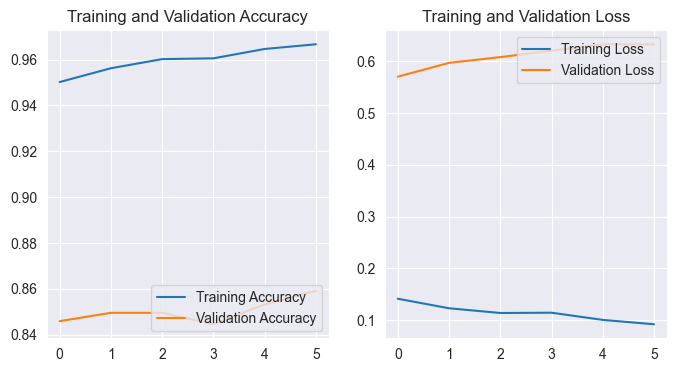

In [57]:
acc = vgg_hist_3.history['accuracy']
val_acc = vgg_hist_3.history['val_accuracy']

loss = vgg_hist_3.history['loss']
val_loss = vgg_hist_3.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
(eval_loss_vgg_3, eval_accuracy_vgg_3) = vgg_model_2.evaluate(val_ds, batch_size=BATCH_SIZE, \
                                            verbose=1)

69/69 [==============================] - 8s 111ms/step - loss: 0.5701 - accuracy: 0.8459


In [59]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy_vgg_3 * 100)) 
print("[INFO] Loss: {}".format(eval_loss_vgg_3)) 

[INFO] accuracy: 84.59%
[INFO] Loss: 0.5701112747192383


1/1 [==============================] - 0s 112ms/step


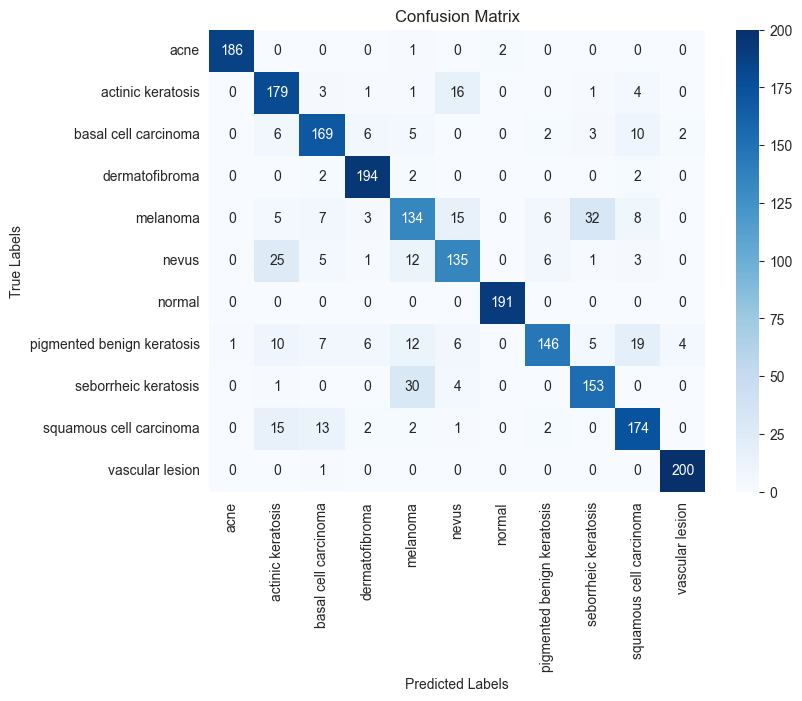

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Melakukan prediksi pada data validasi
y_true = []
y_pred = []

# Mengambil batch dari validasi dan melakukan prediksi
for images, labels in val_ds:
    # Prediksi model terhadap batch gambar
    predictions = vgg_model_2.predict(images)
    
    # Menyimpan label asli dan prediksi
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Mengambil kelas dengan probabilitas tertinggi

# Menghitung confusion matrix
cm = confusion_matrix(np.array(y_true), np.array(y_pred))

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [61]:
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred)

# Menampilkan classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                            precision    recall  f1-score   support

                      acne       0.99      0.98      0.99       189
         actinic keratosis       0.74      0.87      0.80       205
      basal cell carcinoma       0.82      0.83      0.82       203
            dermatofibroma       0.91      0.97      0.94       200
                  melanoma       0.67      0.64      0.66       210
                     nevus       0.76      0.72      0.74       188
                    normal       0.99      1.00      0.99       191
pigmented benign keratosis       0.90      0.68      0.77       216
      seborrheic keratosis       0.78      0.81      0.80       188
   squamous cell carcinoma       0.79      0.83      0.81       209
           vascular lesion       0.97      1.00      0.98       201

                  accuracy                           0.85      2200
                 macro avg       0.85      0.85      0.85      2200
              weighted avg       0.85      0.8

# Train 2nd Model VGG with Adam

In [47]:
opt = Adam(learning_rate=0.001)
vgg_model_2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

checkpoint = ModelCheckpoint('../Model/model_vgg_2_adam.h5', monitor='val_loss', save_best_only=True)

vgg_hist_4 = vgg_model_2.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    epochs=25,
                    validation_data=val_ds,
                    callbacks=[learning_rate_reduction, early_stopping, checkpoint])

Epoch 1/25
275/275 [==============================] - 39s 140ms/step - loss: 0.8319 - accuracy: 0.7477 - val_loss: 0.7849 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 2/25
275/275 [==============================] - 38s 139ms/step - loss: 0.5598 - accuracy: 0.8107 - val_loss: 0.7629 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 3/25
275/275 [==============================] - 39s 140ms/step - loss: 0.4602 - accuracy: 0.8425 - val_loss: 0.6170 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 4/25
275/275 [==============================] - 39s 140ms/step - loss: 0.3868 - accuracy: 0.8708 - val_loss: 0.6032 - val_accuracy: 0.8132 - lr: 0.0010
Epoch 5/25
275/275 [==============================] - 38s 139ms/step - loss: 0.3387 - accuracy: 0.8822 - val_loss: 0.6510 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 6/25
275/275 [==============================] - 38s 138ms/step - loss: 0.2993 - accuracy: 0.9000 - val_loss: 0.6694 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 7/25
275/275 [==============================] 

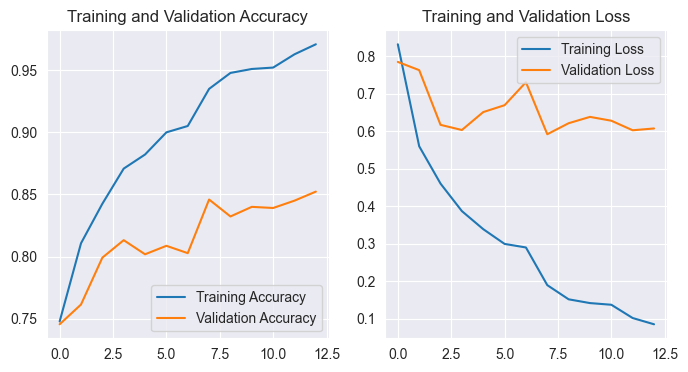

In [50]:
acc = vgg_hist_4.history['accuracy']
val_acc = vgg_hist_4.history['val_accuracy']

loss = vgg_hist_4.history['loss']
val_loss = vgg_hist_4.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
(eval_loss_vgg_4, eval_accuracy_vgg_4) = vgg_model_2.evaluate(val_ds, batch_size=BATCH_SIZE, \
                                            verbose=1)

69/69 [==============================] - 8s 114ms/step - loss: 0.5919 - accuracy: 0.8459


In [ ]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy_vgg_4 * 100)) 
print("[INFO] Loss: {}".format(eval_loss_vgg_4)) 

[INFO] accuracy: 84.59%
[INFO] Loss: 0.591933012008667


1/1 [==============================] - 0s 103ms/step


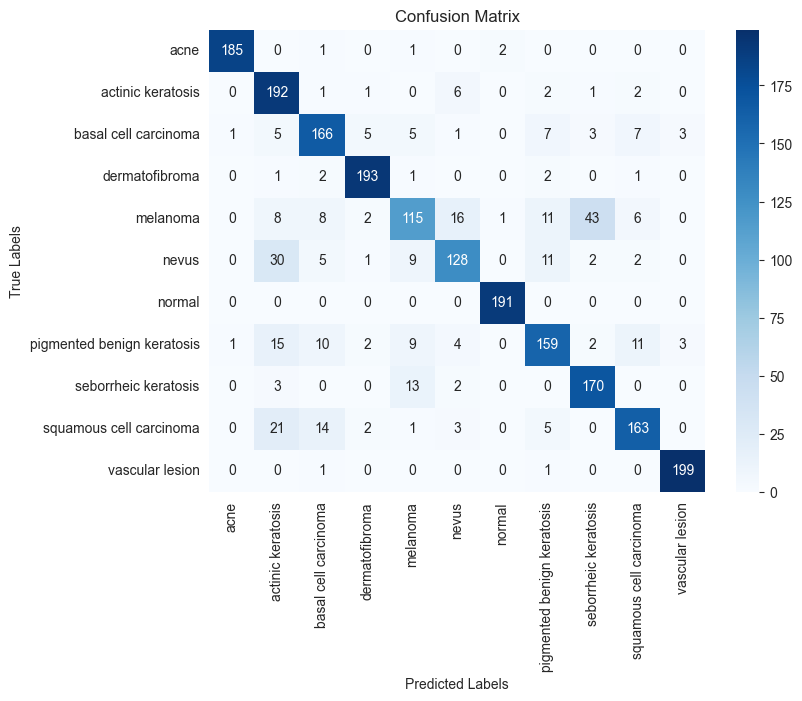

In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Melakukan prediksi pada data validasi
y_true = []
y_pred = []

# Mengambil batch dari validasi dan melakukan prediksi
for images, labels in val_ds:
    # Prediksi model terhadap batch gambar
    predictions = vgg_model_2.predict(images)
    
    # Menyimpan label asli dan prediksi
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Mengambil kelas dengan probabilitas tertinggi

# Menghitung confusion matrix
cm = confusion_matrix(np.array(y_true), np.array(y_pred))

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [55]:
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred)

# Menampilkan classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                            precision    recall  f1-score   support

                      acne       0.99      0.98      0.98       189
         actinic keratosis       0.70      0.94      0.80       205
      basal cell carcinoma       0.80      0.82      0.81       203
            dermatofibroma       0.94      0.96      0.95       200
                  melanoma       0.75      0.55      0.63       210
                     nevus       0.80      0.68      0.74       188
                    normal       0.98      1.00      0.99       191
pigmented benign keratosis       0.80      0.74      0.77       216
      seborrheic keratosis       0.77      0.90      0.83       188
   squamous cell carcinoma       0.85      0.78      0.81       209
           vascular lesion       0.97      0.99      0.98       201

                  accuracy                           0.85      2200
                 macro avg       0.85      0.85      0.84      2200
              weighted avg       0.85      0.8